In [1]:
import numpy as np  
# import pandas as pd
import time

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
# from sklearn import datasets
# from sklearn.model_selection import train_test_split

from typing import Any , Literal
import warnings
warnings.filterwarnings('ignore' ,"" , DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Set Seaborn style
sns.set_style("darkgrid")

In [2]:
from pymoo.algorithms.moo.nsga3 import NSGA3


from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter


```
1: Begin 
2: // Initialization 
3: g ←0; // the generation index 
4: Initialize population Xg and evaluate the fitness; 
5: Initialize the weights of ANN randomly; 
6: Initialize arch as an empty set; // to store solution pairs 
7: While stop criteria not satisfied Do 
8: g ←g + 1; 
9: // Individual Evolution 
10: Sample r uniformly on [0,1]; 
11: If g >1 and r< lp Then 
12: newX ← Evolve Xg by learning-aided evolutionary operator; 
13: Else 
14: // use operators in traditional EC, e.g., PSO or DE 
15: newX ← Evolve Xg by traditional evolutionary operator; 
16: End If
17: Evaluate the fitness of individuals in newX; 
18: // Selection 
19: Xg+1 ← selection among Xg and newX; 
20: // SEP Collection 
21: For each individual i in Xg+1 Do 
22: If Xg+1,i is better than Xg,i Then 
23: Add (Xg,i, Xg+1,i) in arch; 
24: End If 
25: End For 
26: If number of SEPs in arch > arch_size Then 
27: arch ← the newest arch_size solution pairs; 
28: End If 
29: // Learning System Update 
30: Train the ANN with all data in arch for one epoch; 
31: End While 
32: End 
```

In [3]:
# Make Static List

from _collections_abc import dict_items, dict_keys, dict_values
from collections.abc import Iterator



class static_list(list):

    def __init__(self, volume: int) -> None:
        self.volume = volume
        self.x = list()
        pass
    def __str__(self) -> str:
        return f"{self.x}"
    def __repr__(self) -> str:
        return f"static_list({self.x})"
    def __iter__(self) -> Iterator:
        return self.x.__iter__()
    
    def append(self, value : Any , sorted : bool = False):
        if len(self.x) == self.volume:
            self.x.append(  value )
            self.x.pop(0)
            self.x.sort(reverse = True) if sorted else None
        else :
            self.x.append(  value )
            self.x.sort(reverse = True) if sorted else None
        self.__repr__()
        pass

        
    def to_list(self) -> list:
        return self.x


class static_dict(dict):

    def __init__(self, volume: int) -> None:
        self.volume = volume
        self.x = dict()
        pass
    def __str__(self) -> str:
        return f"{self.x}"
    def __repr__(self) -> str:
        return f"static_dict({self.x})"
    def keys(self) -> dict_keys:
        return list(self.x.keys())
    def values(self) -> dict_values:
        return list(self.x.values())
    def items(self) -> dict_items:
        return list(self.x.items())
    def __iter__(self) -> Iterator:
        return self.x.__iter__()
    
    def add(self, value : tuple):
        if len(self.x) == self.volume:
            self.x[value[0]] =  value[1]
            self.x.pop( list(self.x.keys()) [0])
        else :
            self.x[value[0]] =  value[1]

        self.__repr__()
        pass


In [4]:

def ackley(x):
    """
    Ackley function implementation.
    
    Parameters:
    x (numpy.ndarray): Input vector (solution).
    
    Returns:
    float: Value of the Ackley function at the given input vector.
    """
    a = 20
    b = 0.2
    c = 2 * np.pi
    
    term1 = -a * np.exp(-b * np.sqrt((1 / len(x)) * np.sum(x**2)))
    term2 = -np.exp((1 / len(x)) * np.sum(np.cos(c * x)))
    
    value = term1 + term2 + a + np.exp(1)
    
    return value


def dtlz1(solution, n_vars):
    g = sum([(x - 0.5) ** 2 - np.cos(20 * np.pi * (x - 0.5)) for x in solution[n_vars - 1:]])
    g += 100 * (n_vars - 1)
    f = [(1 + g) * np.prod(solution[:n_vars - 1])]
    for i in range(1, n_vars - 1):
        f.append((1 + g) * np.prod(solution[:n_vars - 1 - i]) * (1 - solution[n_vars - 1 - i]))
    f.append((1 + g) * (1 - solution[0]))
    return np.array(f)

# DTLZ2
def dtlz2(solution, n_vars):
    g = sum([(x - 0.5) ** 2 - np.cos(20 * np.pi * (x - 0.5)) for x in solution[n_vars - 1:]])
    f = [(1 + g) * np.prod(np.cos(np.array(solution[:n_vars - 1]) * np.pi / 2))]
    for i in range(1, n_vars - 1):
        f.append((1 + g) * np.prod(np.cos(np.array(solution[:n_vars - 1 - i]) * np.pi / 2)) * np.sin(np.pi / 2 * solution[n_vars - 1 - i]))
    f.append((1 + g) * np.sin(np.pi / 2 * solution[0]))
    return np.array(f)

# DTLZ3
def dtlz3(solution, n_vars):
    g = sum([(x - 0.5) ** 2 - np.cos(20 * np.pi * (x - 0.5)) for x in solution[n_vars - 1:]])
    f = [(1 + g) * np.prod(np.cos(np.array(solution[:n_vars - 1]) * np.pi / 2))]
    for i in range(1, n_vars - 1):
        f.append((1 + g) * np.prod(np.cos(np.array(solution[:n_vars - 1 - i]) * np.pi / 2)) * np.sin(np.pi / 2 * solution[n_vars - 1 - i]))
    f.append((1 + g) * np.sin(np.pi / 2 * solution[0]))
    return np.array(f)

# DTLZ4
def dtlz4(solution, n_vars):
    g = sum([(x - 0.5) ** 2 - np.cos(20 * np.pi * (x - 0.5)) for x in solution[n_vars - 1:]])
    f = [(1 + g) * np.prod(np.cos(100 * np.array(solution[:n_vars - 1]) * np.pi / 2))]
    for i in range(1, n_vars - 1):
        f.append((1 + g) * np.prod(np.cos(100 * np.array(solution[:n_vars - 1 - i]) * np.pi / 2)) * np.sin(100 * np.pi / 2 * solution[n_vars - 1 - i]))
    f.append((1 + g) * np.sin(100 * np.pi / 2 * solution[0]))
    return np.array(f)

# DTLZ5
def dtlz5(solution, n_vars):
    g = sum([(x - 0.5) ** 2 - np.cos(20 * np.pi * (x - 0.5)) for x in solution[n_vars - 1:]])
    f = [(1 + g) * np.prod(np.cos(6 * np.array(solution[:n_vars - 1]) * np.pi / 2))]
    for i in range(1, n_vars - 1):
        f.append((1 + g) * np.prod(np.cos(6 * np.array(solution[:n_vars - 1 - i]) * np.pi / 2)) * np.sin(6 * np.pi / 2 * solution[n_vars - 1 - i]))
    f.append((1 + g) * np.sin(6 * np.pi / 2 * solution[0]))
    return np.array(f)

# DTLZ6
def dtlz6(solution, n_vars):
    g = sum([(x - 0.5) ** 2 for x in solution[n_vars - 1:]])
    f = [(1 + g) * (1 - np.cos(solution[0] * np.pi / 2))]
    for i in range(1, n_vars - 1):
        f.append((1 + g) * (1 - np.cos(solution[i] * np.pi / 2)) * np.prod([np.sin(solution[j] * np.pi / 2) for j in range(n_vars - 1 - i)]))
    return np.array(f)

# DTLZ7
def dtlz7(solution, n_vars):
    g = 1 + (9 / len(solution)) * sum(solution[n_vars - 1:])
    f1 = solution[0]
    h = n_vars - sum([(x / (1 + g)) * (1 + np.sin(3 * np.pi * x)) for x in solution[:n_vars - 1]])
    f2 = (1 + g) * h
    return np.array([f1, f2])




In [5]:

# def evaluate_fitness(function, *args, **kwargs):

#   start_time = time.time()
#   LX = function(*args, **kwargs)
#   end_time = time.time()
#   time_delay = (end_time - start_time) * 1000 
#   return time_delay , LX
def evaluate_population(func , solution, n_vars):
    evaluated_population = []
    # for solution in population:
    evaluated_solution = func(solution, n_vars)
    # evaluated_population.append((solution, evaluated_solution))
    return (solution, evaluated_solution)


def ackley_fitness(x):
    """
    Ackley fitness function implementation.
    
    Parameters:
    x (numpy.ndarray): Input vector (solution).
    
    Returns:
    float: Fitness value of the Ackley function at the given input vector.
    """
    a = 20
    b = 0.2
    c = 2 * np.pi
    
    term1 = -a * np.exp(-b * np.sqrt((1 / len(x)) * np.sum(x**2)))
    term2 = -np.exp((1 / len(x)) * np.sum(np.cos(c * x)))
    
    value = term1 + term2 + a + np.exp(1)
    
    # Convert to negative for minimization
    fitness = -value
    
    return x, [fitness, fitness]


def fitness(name : str, x, n_objective):

    match name:
        case "dtlz1":
            return evaluate_population(dtlz1 , x, n_objective)
        case "dtlz2":
            return evaluate_population(dtlz2 , x, n_objective)
        case "dtlz3":
            return evaluate_population(dtlz3 , x, n_objective)
        case "dtlz4":
            return evaluate_population(dtlz4 , x, n_objective)
        case "dtlz5":
            return evaluate_population(dtlz5 , x, n_objective)
        case "dtlz6":
            return evaluate_population(dtlz6 , x, n_objective)
        case "dtlz7":
            return evaluate_population(dtlz7 , x, n_objective)
        case "ackley":
            return ackley_fitness(x)
        case _ :
            raise ValueError("bad arg")
        
        


In [6]:
# initialize_ANN
def initialize_ANN(xtrain, n_obj):
# Create the modelweights_randomly
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(xtrain.shape[1],)),
        tf.keras.layers.Dense(xtrain.shape[1] * 3, activation='relu'),
        tf.keras.layers.Dense(n_obj , activation = "sigmoid")
    ])

    model.compile(optimizer=Adam(.1), loss='mse')
    return model

In [7]:
class kerasModel:
    def __init__(self) -> None:
        pass
    def __str__(self) -> str:
        return "kerasModel"
    def __repr__(self) -> str:
        return self.__str__()
    

In [8]:
# train_ANN
def train_ANN(model, X_train, y_train) -> np.ndarray:

    # model.compile(optimizer=Adam(0.1), loss='mse')  # Corrected the learning rate
    hist = model.fit(X_train, y_train, epochs=1, verbose=False)
    ypred = model.predict(X_train, verbose=False)
    return ypred[0]


In [9]:
# Placeholder functions for specific implementations
def initialize_population(population_size, num_variables) -> np.ndarray:
    """
    Generates initial population for evolutionary algorithm.

    Parameters:
    - population_size: Size of the population.
    - num_variables: Number of decision variables.
    - variable_ranges: List of tuples specifying the ranges of each variable.

    Returns:
    - initial_population: 2D NumPy array representing the initial population.
    """
    initial_population = []
    variable_ranges = [(-5.0, 5.0)] * num_variables
    for _ in range(population_size):
        solution = []
        for i in range(num_variables):
            var_range = variable_ranges[i]
            var_value = np.random.uniform(var_range[0], var_range[1])
            solution.append(var_value)
        initial_population.append(solution)

    return np.array(initial_population)



# def initialize_population(population_size, num_variables):
#     x1 = np.random.uniform(0,1, population_size)
#     x2to5 = np.tile(np.random.rand(), [num_variables, population_size])
#     x = np.vstack((x1, x2to5))
#     return x


In [10]:
def MSE(arch_size, Lx, X):
    # Lx = np.argmax(Lx, axis=1)
    summ = np.sum(np.abs(Lx - X) ** 2)
    return (1/arch_size) * summ

In [11]:
def cross_over(X_A, X_B, mutaion_over_rate):
    if np.random.rand() <= mutaion_over_rate:
        return X_A
    else:
        return X_B
    
def mutation(X_A, X_B,X_C, cross_over_rate):
    """
    XA + cross_over_rate * (XB - Xc)
    """
    return X_A + cross_over_rate * (X_B - X_C)

In [12]:
def learning_aided_evolution(Xg, cross_over_rate, mutaion_over_rate):
    newX = list()
    for i in range(1, len(Xg) ):
        LC = cross_over(Xg[1-i] , Xg[i ], cross_over_rate)
        # x = fitness("dtlz1",LC)
        newX.append(LC)

    for i in range(2, len(Xg) ):
        LM = mutation( Xg[i - 2], Xg[i - 1], Xg[i], mutaion_over_rate)
        # x = fitness("dtlz1", LM )
        # leo_result[ff] = x
        newX.append(LM)
    return np.array(newX)

In [13]:
def is_better(problem, individual1, individual2, n_objective):
    individual1, fitness_individual1 = fitness( problem,individual1, n_objective)
    individual2, fitness_individual2 = fitness( problem,individual2, n_objective)
    # print(fitness_individual2)
    if fitness_individual1[1] < fitness_individual2[1]:
        
        return True
    else:
        return False

In [14]:
def selection(problem,
              Xg :Any, 
              newX : Any,
              n_var):
               
    selected = list()
    for  i , j in zip (Xg, newX):
        if is_better(problem, i, j, n_var):
            selected.append( i )
        else :
            selected.append(j)

    return np.array(selected)

In [44]:
def main(problem : Literal["dtlz1", "dtlz2", "dtlz3", "dtlz4", "dtlz5", "dtlz6", "dtlz7","ackley" ] = "ackley" ,
         arch_size : int = 10,
         lp : float = .5,
         n_generation : int = 2,
         first_gen_size = 100, 
         n_obj: int = 3,
         n_var = 5 ,
         cross_over_rate = .5 , # cross-over rate
         mutaion_over_rate = .5 ,  # mutation rate
         plot : bool = False):


    Xg  : np.ndarray = initialize_population(first_gen_size, n_var )  # Initialize population and evaluate fitness
    ANN = initialize_ANN(Xg, n_obj)  # Initialize ANN weights randomly
    archive = static_list(arch_size)  # Archive to store solution pairs
    
    # newX = Xg
    
    for gen in range(n_generation):
        print(f"{gen+1}=", end= "")

        r = np.random.rand()
        if gen > 1 and r < lp:
            newX = learning_aided_evolution(Xg, cross_over_rate=cross_over_rate, mutaion_over_rate=mutaion_over_rate)
        else:
            newX = Xg

        # Selection
        Xg_1 = selection(problem, Xg, newX, n_var)
        
        # SEP Collection
        for i in range(len(Xg_1) - 1) :
            if is_better(problem ,Xg_1[i+1], Xg_1[i ], n_var):  
                archive.append(( Xg_1[ i ], 
                                 Xg_1[i + 1]))
                
        all_solutions = list()
        all_losses = list()
        for m1, m2 in archive:
            model1 = train_ANN(ANN, m1.reshape(1,-1 ), m1.reshape(1,-1 ))
            model2 = train_ANN(ANN, m2.reshape(1,-1 ), m2.reshape(1,-1 ))
            all_solutions.append(model1)
            all_solutions.append(model2)
        
            loss1 = MSE(arch_size, model1, m1 )
            loss2 = MSE(arch_size, model2, m2 )
            all_losses.append( np.mean([loss1, loss2]) )
            
        all_solutions = np.array(all_solutions) 

    if plot:
        fig, ax = plt.subplots(1,3 , figsize=(15, 5))
        sns.lineplot(Xg,            legend=False , ax=ax [0] )
        ax[0].set_xlabel('initialize population' , fontsize = 10)
        ax[0].grid(visible =True)

        sns.lineplot(all_solutions, legend=False , ax=ax [1] )
        ax[1].set_xlabel('solution population' , fontsize = 10)
        ax[1].grid(visible =True)

        sns.lineplot(all_losses,    legend=False , ax=ax [2] )
        ax[2].set_xlabel('MSE loss ' , fontsize = 10)

        ax[2].grid(visible =True)
        plt.show()
    
    # return np.array(sorted(all_solutions, key= lambda x : x[0]))
    return all_solutions



In [52]:
res = main(problem= "ackley",
            arch_size = 100,
            first_gen_size = 100,
            lp= .1,
            n_obj = 1 ,
            n_generation= 5,
            n_var= 3 ,
            cross_over_rate = .5,
            mutaion_over_rate = .5 ,
            plot= False)

1=2=3=4=5=

In [56]:
print(res)

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.67459700e-38]
 [8.71763357e-38]
 [2.89684378e-37]
 [2.59858814e-36]
 [1.11633981e-35]
 [1.67865977e-34]
 [6.54123530e-34]
 [1.06413151e-33]
 [1.42100792e-33]
 [1.05483235e-32]
 [2.62426598e-31]
 [4.22602256e-30]
 [4.92912467e-30]
 [5.74017627e-30]
 [1.05054919e-29]
 [1.95007193e-29]
 [2.50945109e-28]
 [5.90488965e-28]
 [8.72832606e-28]
 [5.64593412e-27]
 [1.29017523e-26]
 [9.615536

<Axes: >

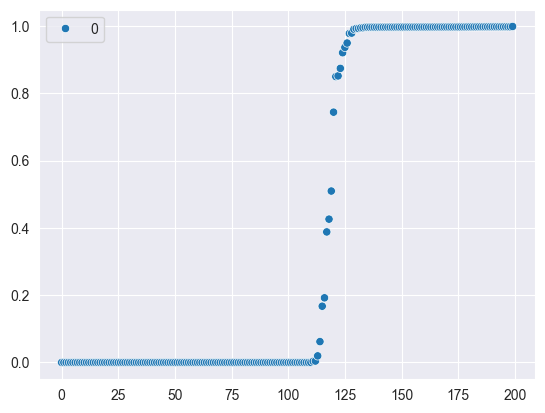

In [55]:
sns.scatterplot(res)

In [48]:
%matplotlib qt


In [50]:
%matplotlib inline

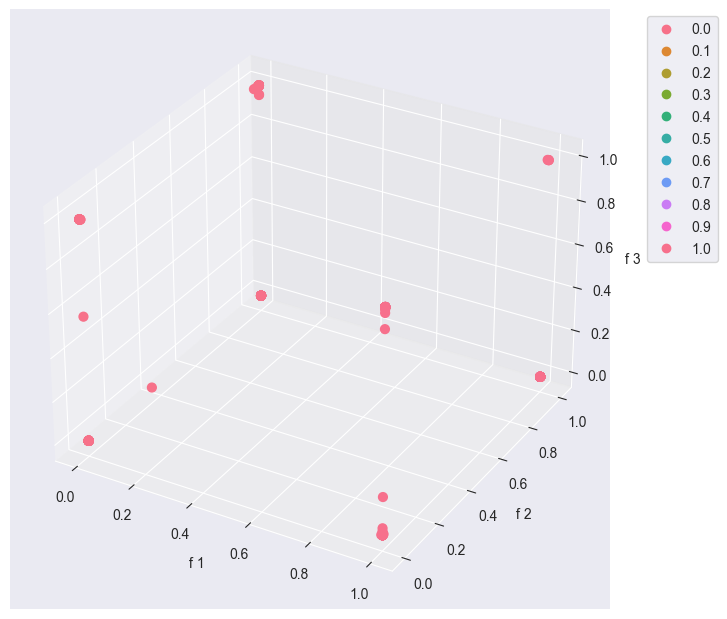

In [51]:


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Scatter plot
sc = ax.scatter(res[:,0], res[:,1], res[:,2], s=40, c=res[:,0], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('f 1')
ax.set_ylabel('f 2')
ax.set_zlabel('f 3')

# Legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Show plot
plt.show(block = False)


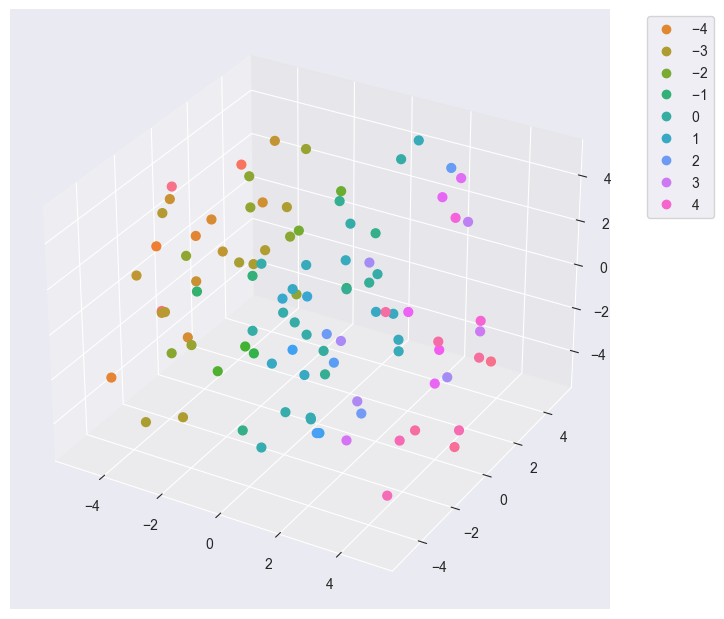

In [21]:
Xg  = initialize_population(100, 3 ) 

fig = plt.figure(figsize=(6,6))
ax1 = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax1)

# Get colormap from Seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# Sca
scXg = ax1.scatter(Xg[:,0], Xg[:,1], Xg[:,2], s=40, c=Xg[:,0], marker='o', cmap=cmap, alpha=1)
plt.legend(*scXg. legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
ax.set_xlabel('f 1')
ax.set_ylabel('f 2')
ax.set_zlabel('f 3')
# Show plot
plt.show()


In [22]:
# import scipy.stats as stats

# # Sample data (adjust according to your data)
# sample1 = [10, 12, 8, 15, 9]
# sample2 = [11, 14, 6, 18, 13]

# # One-sided test (alternative hypothesis: sample1 > sample2)
# statistic, pvalue = stats.wilcoxon(sample1, sample2, alternative='greater')
# print("One-sided p-value:", pvalue)

# # Two-sided test (alternative hypothesis: not equal medians)
# statistic, pvalue = stats.wilcoxon(sample1, sample2, alternative='two-sided')
# print("Two-sided p-value:", pvalue)

# # Interpretation:
# # if pvalue < 0.05 (common significance level), reject the null hypothesis (no difference) and conclude that there's a statistically significant difference between the samples.

# # Additional steps:
# # - Consider Bonferroni correction for multiple comparisons.
# # - Visualize data distributions and rank differences for deeper insights.


In [23]:
# import pandas as pd
# from scipy.stats import friedmanchisquare
# from scikit_posthocs import posthoc_nemenyi

# # Create a pandas DataFrame with your data (replace with your actual data)
# df = pd.DataFrame({
#     'Group1': [1, 2, 3],
#     'Group2': [2, 3, 4],
#     'Group3': [3, 4, 5],
#     # Add more groups if needed
# })

# # Perform the Friedman test
# friedman_result = friedmanchisquare(df['Group1'].to_numpy()
#                                     ,df['Group2'].to_numpy()
#                                     ,df['Group3'].to_numpy())

# # If significant, proceed with post-hoc analysis
# if friedman_result.pvalue < 0.05:
#     posthoc_result = posthoc_nemenyi(df)
#     print(posthoc_result)
# else:
#     print("No significant differences detected.")


In [24]:
# # Import necessary libraries
# import numpy as np
# import tensorflow as tf

# # Define the Learning-Aided Evolution for Optimization (LEO) class
# class LEO:
#     def __init__(self, input_dim, output_dim):
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.model = self.build_model()

#     # Build the artificial neural network (ANN) model
#     def build_model(self):
#         model = tf.keras.Sequential([
#             tf.keras.layers.Dense(64, activation='relu', input_shape=(self.input_dim,)),
#             tf.keras.layers.Dense(64, activation='relu'),
#             tf.keras.layers.Dense(self.output_dim)
#         ])
#         model.compile(optimizer='adam', loss='mean_squared_error')
#         return model

#     # Train the ANN with successful solution pairs
#     def train(self, X, y):
#         self.model.fit(X, y, epochs=10, batch_size=32, verbose = False)

#     # Use the trained ANN to aid the evolutionary process
#     def evolve(self, input_solution):
#         evolved_solution = self.model.predict(input_solution)
#         return evolved_solution

# # Example usage
# # Initialize LEO with input and output dimensions
# input_dim = 10  # Example input dimension
# output_dim = 1  # Example output dimension
# leo = LEO(input_dim, output_dim)

# # Generate successful solution pairs (X, y)
# X = np.random.rand(100, input_dim)  # Example input data
# y = np.random.rand(100, output_dim)  # Example output data


# # Train LEO with successful solution pairs
# d = evaluate_fitness(leo.train, X , y)
# # leo.train(X, y)
# print("d ", d)
# # Use LEO to aid the evolutionary process
# input_solution = np.random.rand(1, input_dim)  # Example input solution
# evolved_solution = leo.evolve(input_solution)
# print(evolved_solution)

In [25]:
# import random
# import tensorflow as tf
# from tensorflow import keras
# from keras.optimizers import Adam

# arch_size = 100
# lp = None
# generation = 10

# cross_over_rate = .5
# mutaion_over_rate = .9

# def main():
#     g = 0  # Generation index
#     Xg = initialize_population()  # Initialize population and evaluate fitness
#     ANN = initialize_ANN()  # Initialize ANN weights randomly
#     arch = static_dict(arch_size)  # Archive to store solution pairs

#     for _ in range(generation):
#         g += 1

#         # Individual Evolution
#         r = random.random()
#         if g > 1 and r < lp:
#             newX = learning_aided_evolution(Xg)
#         else:
#             newX = traditional_evolution(Xg)

#         evaluate_fitness(newX)

#         # Selection
#         Xg = selection(Xg, newX)

#         # SEP Collection
#         for i in range(len(Xg)):
#             if is_better(Xg[i], Xg_prev[i]):  # Assuming Xg_prev is accessible
#                 arch.append((Xg_prev[i], Xg[i]))

#         # if len(arch) > arch_size:
#         #     arch = arch[-arch_size:]  # Keep newest arch_size pairs

#         # Learning System Update
#         train_ANN(ANN, arch)

#         Xg_prev = Xg  # Store Xg for next iteration

# # Placeholder functions for specific implementations
# def initialize_population():
#     # ...
#     pass

# def initialize_ANN():
#     # Define hyperparameters
#     input_size = 1  # Adjust this for your actual input size
#     hidden_size = 10  # Adjust this for your desired hidden layer size
#     output_size = 1  # Adjust this for your desired output size

# # Create the model
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(hidden_size, activation='relu', input_shape=(input_size,)),
#         tf.keras.layers.Dense(output_size)
#     ])

#     # Compile the model
#     model.compile(optimizer=Adam(.1), loss='mse', metrics=['mae'])


# def learning_aided_evolution(Xg):

#     # ...
#     pass

# def traditional_evolution(Xg):
#     # ...
#     pass

# def evaluate_fitness(function, *args, **kwargs):
#   start_time = time.time()
#   function(*args, **kwargs)
#   end_time = time.time()
#   time_delay = (end_time - start_time) * 1000 
#   return time_delay

# def selection(Xg, newX):
#     # ...
#     pass

# def is_better(individual1, individual2):
#     # ...
#     pass

# def train_ANN(ANN, arch):
#     # ...
#     pass

# if __name__ == "__main__":
#     main()


In [26]:
# def ETR(A, B):
#   """
#   Calculates the error reduction versus time increase rate (ETR) between two algorithms.

#   Args:
#     A: Dictionary containing information about algorithm A, including:
#       - `error`: The optimization error of algorithm A.
#       - `time`: The computational time cost of algorithm A.
#     B: Dictionary containing information about algorithm B, including:
#       - `error`: The optimization error of algorithm B.
#       - `time`: The computational time cost of algorithm B.

#   Returns:
#     The ETR value of algorithm A over B, or None if B's error is better than A's.
#   """

#   # Check if algorithm B has a better error than A
#   if B["error"] <= A["error"]:
#     return None

#   # Calculate error reduction rate
#   err_reduction_rate = (A["error"] - B["error"]) / B["error"] * 100

#   # Calculate time increase rate
#   time_increase_rate = (A["time"] - B["time"]) / B["time"] * 100

#   # Check for division by zero
#   if time_increase_rate == 0:
#     return None

#   # Calculate ETR
#   return err_reduction_rate / time_increase_rate

# # Example usage
# algorithm_a = {"error": 0.2, "time": 100}
# algorithm_b = {"error": 0.5, "time": 50}

# etr_value = ETR(algorithm_a, algorithm_b)

# if etr_value is not None:
#   print(f"ETR of algorithm A over B: {etr_value:.2f}%")
# else:
#   print("Algorithm B has a better error, ETR cannot be calculated.")
